<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/IndicBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [2]:
# Load dataset
file_path = '/content/balanced_dataset.csv'  # Update for Colab
data = pd.read_csv(file_path)

# Select relevant columns
data = data[['text', 'sentiment_numeric']]
data = data.dropna()

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(),
    data['sentiment_numeric'].tolist(),
    test_size=0.2,
    random_state=42
)

In [3]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in tokens.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

In [4]:
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    'ai4bharat/indic-bert',
    num_labels=len(set(data['sentiment_numeric']))
)

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-d879a24eab2e>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.096100,1.094724
2,0.984000,1.025355
3,0.950800,1.001836


TrainOutput(global_step=585, training_loss=1.0560390130067483, metrics={'train_runtime': 227.1044, 'train_samples_per_second': 41.056, 'train_steps_per_second': 2.576, 'total_flos': 55711981882368.0, 'train_loss': 1.0560390130067483, 'epoch': 3.0})

In [6]:
# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 1.0018361806869507, 'eval_runtime': 5.8726, 'eval_samples_per_second': 132.308, 'eval_steps_per_second': 8.344, 'epoch': 3.0}


In [7]:
# Predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(test_labels, preds, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.46      0.81      0.59       273
     Neutral       0.29      0.09      0.13       230
    Positive       0.67      0.56      0.61       274

    accuracy                           0.51       777
   macro avg       0.47      0.48      0.44       777
weighted avg       0.48      0.51      0.46       777



In [8]:
print("Confusion Matrix:")
conf_matrix = confusion_matrix(test_labels, preds)
print(conf_matrix)

Confusion Matrix:
[[220  23  30]
 [163  20  47]
 [ 95  26 153]]


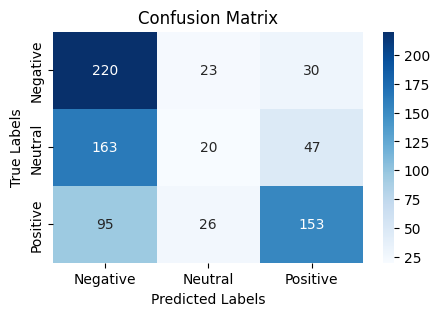

In [9]:
# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-10-d70075887db6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['sentiment_numeric'], palette='viridis')


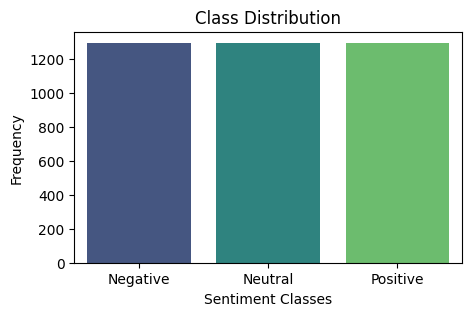

In [10]:
# Plot class distribution
plt.figure(figsize=(5, 3))
sns.countplot(x=data['sentiment_numeric'], palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Sentiment Classes')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

In [11]:
# Predict sentiment for user input
def predict_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    sentiment_labels = {
        0: {"English": "Negative", "Kannada": "ನಕಾರಾತ್ಮಕ"},
        1: {"English": "Neutral", "Kannada": "ತಟಸ್ಥ"},
        2: {"English": "Positive", "Kannada": "ಧನಾತ್ಮಕ"}
    }
    return sentiment_labels[prediction]

# Take user input
user_input = input("Enter a Kannada sentence for sentiment prediction: ")
predicted_sentiment = predict_sentiment(user_input)
print(f"Predicted Sentiment: {predicted_sentiment['English']} ({predicted_sentiment['Kannada']})")

Enter a Kannada sentence for sentiment prediction: ನಾನು ಖಿನ್ನತೆಗೆ ಒಳಗಾಗಿದ್ದೇನೆ
Predicted Sentiment: Negative (ನಕಾರಾತ್ಮಕ)
